# Bayesian Logistic Regression Modules

This notebook tests the modules that perform logistic regression.

In [2]:
### Libraries

import matplotlib, matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pymc

% matplotlib inline

In [3]:
### Custom Modules

import bayes_lr
import game_predictions

In [26]:
### Reloading Examples

bayes_lr = reload(bayes_lr)
game_predictions = reload(game_predictions)

In [7]:
### Settings

# Games path.
games_path = 'games.csv'

## Data

In [8]:
# Read games.
games = pd.read_csv(games_path)
# Trim to single group.
games = games[games.game_group == 1].reset_index(drop=True)
# 2014 games.
games_2014 = games[games.year == 2014].reset_index(drop=True)

## Model

In [13]:
# Slicer
def model_games_slicer (
    data,
    features=['team_Pythag'],
    coef_dists=None,
    coef_dist_params=None,
    b0_params={'mu':0, 'tau':0.0003, 'value':0},
    err_params=[.5],
    default_coef_dist = pymc.Normal,
    default_coef_params = {'mu':0, 'tau':0.0003, 'value':0},
    step_method = pymc.Metropolis,
    step_method_params = None,
    default_step_method_params = {'proposal_sd':1., 'proposal_distribution':'Normal'}
):
    """
    Inputs:
        data: Pandas dataframe of game information.
        features: String list of features from game data.
        coef_dists: Distribution for coefficients. Default: see default_coef_dist; usually Normal.
        coef_dist_params: List of dictionaries that parameterize coeficient distributions.
        b0_params: Parameters for intercept ("b0"). Default: mean=0, precision=0.0003; initial value=0.
        err_params: Parameters list for Bernoulli-distribued error distribution. Default: p=0.5.
        default_coef_dist: Coefficient distributions.
        default_coef_params: Default coefficient distribution parameters.
        step_method: MCMC stepping method.
        step_method_params: Parameters for stepping method for each coefficient. Default: see default_step_method_params.
        default_step_method_params: Default step method parameters for coefficient draws.
    Returns:
        PyMC MCMC object. Call with .sample() and desired parameters to perform actual sampling.
    """
    
    # Define priors on intercept and error. PyMC uses precision (inverse variance).
    b0 = pymc.Normal('b_0', **b0_params)
    err = pymc.Bernoulli('err', *err_params)
    
    # Containers for coefficients and data.
    b = np.empty(len(features), dtype=object)
    x = np.empty(len(features), dtype=object)
    
    # Traverse features.
    for i, f in enumerate(features):
        # Coefficient.
        # First start with the distribution. Use one if we've been given one; else use default.
        coef_dist_type = default_coef_dist if coef_dists is None or coef_dists[i] is None else coef_dists[i]
        # Now handle parameters.
        this_coef_dist_params = default_coef_params if coef_dist_params is None or coef_dist_params[i] is None else coef_dist_params[i]
        # Now actually create the coefficient distribution
        b[i] = coef_dist_type('b_'+f, **this_coef_dist_params)
        # Data distribution.
        x[i] = pymc.Normal('x_'+f, 0, 1, value=np.array(data[f]), observed=True)
    
    # Logistic function.
    @pymc.deterministic
    def logistic(b0=b0, b=b, x=x):
        return 1.0 / (1. + np.exp(-(b0 + b.dot(x))))

    # Get outcome data.
    y = np.array(data.win)
    # Model outcome as a Bernoulli distribution.
    y = pymc.Bernoulli('win', logistic, value=y, observed=True)
    
    # Define model, MCMC object.
    model = pymc.Model([logistic, pymc.Container(b), err, pymc.Container(x), y])
    mcmc  = pymc.MCMC(model)
    
    # Configure step methods.
    for var in list(b)+[b0,err]:
        coef_step_method_params = default_step_method_params if step_method_params is None or step_method_params[i] is None else step_method_params[i]
        mcmc.use_step_method(step_method, stochastic=var)
    
    # Return MCMC object.
    return mcmc

In [10]:
# Features.
features = ['location_Home','diff_RankAdjTempo','diff_OE','diff_DE','diff_RankPythag']
model_mcmc = bayes_lr.model_games(data=games_2014,features=features)

In [14]:
model_mcmc = model_games_slicer(data=games_2014, features=features, step_method = pymc.Slicer)

In [15]:
# Slicer
# model_mcmc.sample(10000,2000) # no thin


 [-----------------100%-----------------] 10000 of 10000 complete in 157.8 sec

In [19]:
model_mcmc.sample(10000,2000, thin=10) # w/ thin

 [-----------------100%-----------------] 10000 of 10000 complete in 143.0 sec

In [27]:
# Slice sampling
# use bayes_lr.model_games
model_mcmc = bayes_lr.model_games(data=games_2014, features=features, step_method = pymc.Slicer)
model_mcmc.sample(10000,2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 168.3 sec

In [31]:
# MH
# model_mcmc = bayes_lr.model_games(data=games_2014, features=features)
# model_mcmc.sample(10000,2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 17.7 sec

## Diagnostics

Plotting b_diff_RankAdjTempo
Plotting b_diff_RankPythag
Plotting b_diff_DE
Plotting b_location_Home
Plotting err
Plotting b_diff_OE
Plotting b_0


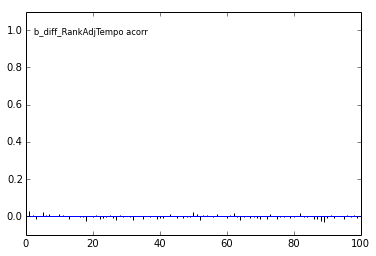

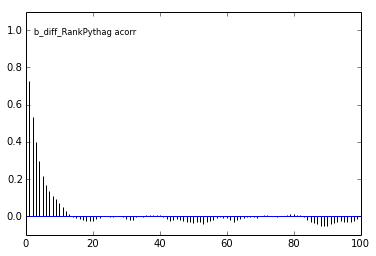

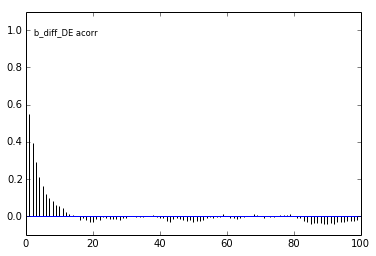

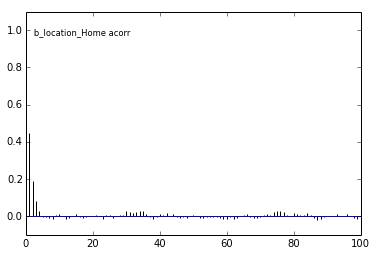

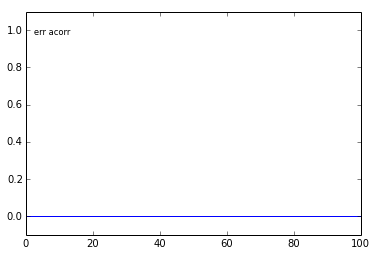

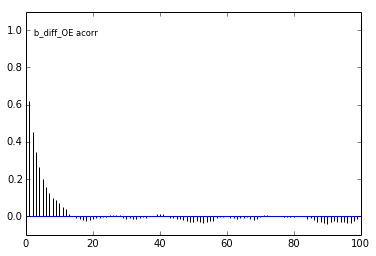

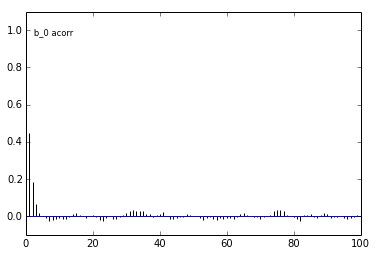

In [16]:
# Slicer with No thinning
pymc.Matplot.autocorrelation(model_mcmc)

Plotting b_diff_RankAdjTempo
Plotting b_diff_RankPythag
Plotting b_diff_DE
Plotting b_location_Home
Plotting err
Plotting b_diff_OE
Plotting b_0


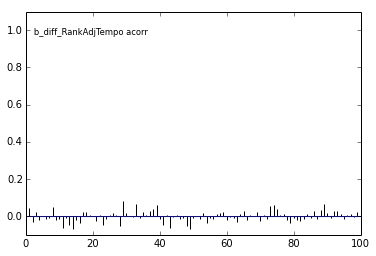

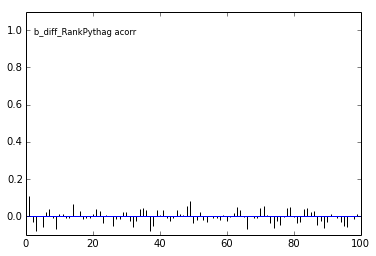

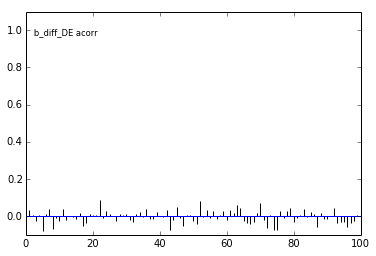

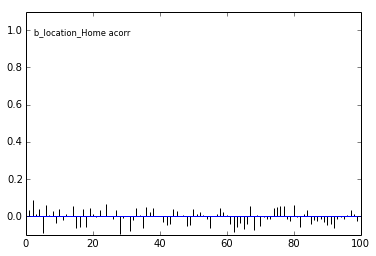

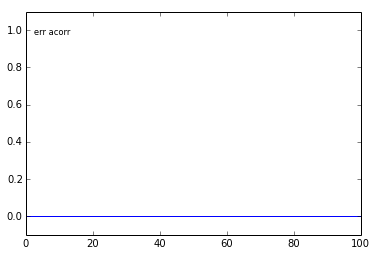

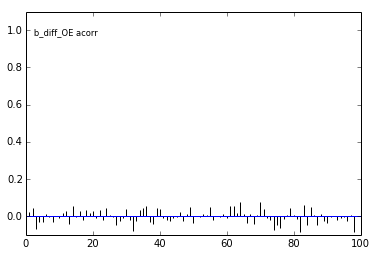

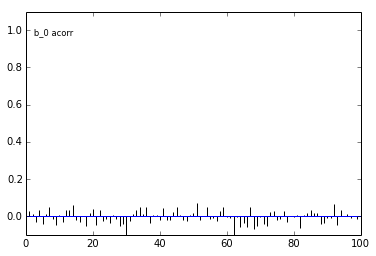

In [20]:
# With Thinning!
pymc.Matplot.autocorrelation(model_mcmc)

location_Home
diff_RankAdjTempo
diff_OE
diff_DE
diff_RankPythag


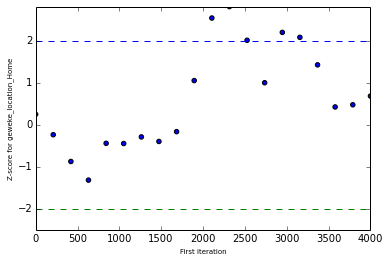

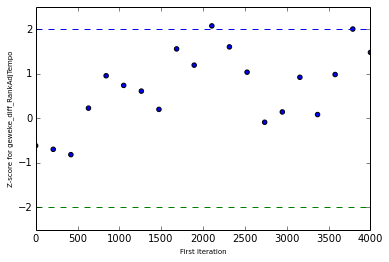

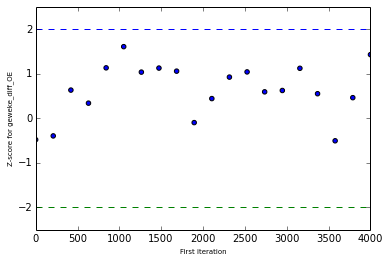

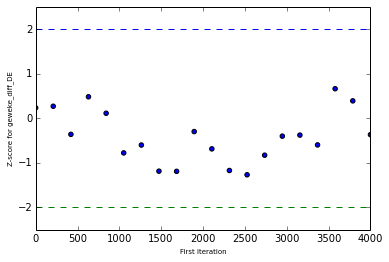

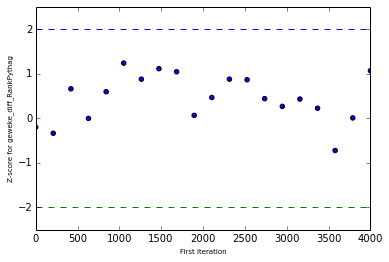

In [17]:
# Geweke Test
for feature in features:
    print feature
    scores = pymc.geweke(model_mcmc.trace('b_'+feature)[:])
    pymc.Matplot.geweke_plot(scores, name = 'geweke_'+feature)

location_Home
diff_RankAdjTempo
diff_OE
diff_DE
diff_RankPythag


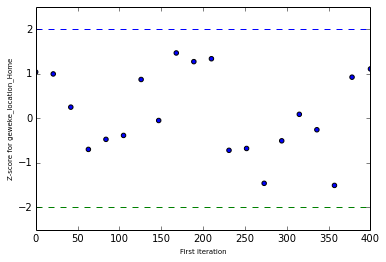

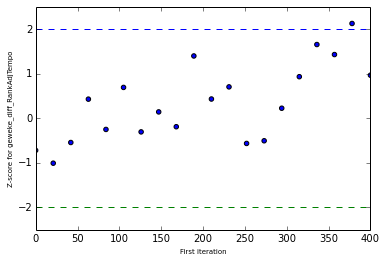

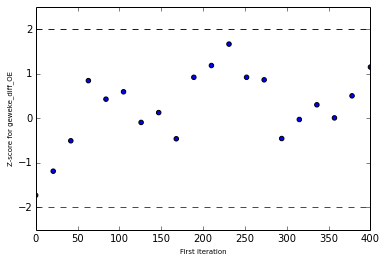

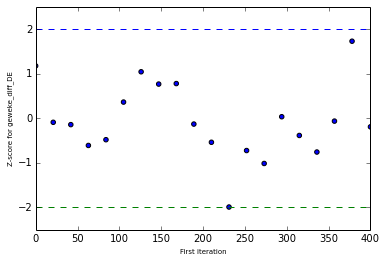

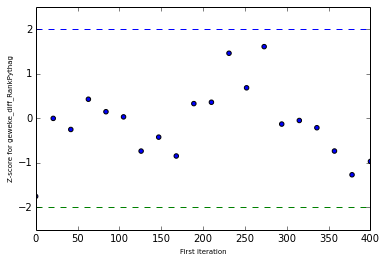

In [21]:
# With thinning
# Geweke Test
for feature in features:
    print feature
    scores = pymc.geweke(model_mcmc.trace('b_'+feature)[:])
    pymc.Matplot.geweke_plot(scores, name = 'geweke_'+feature)

In [38]:
# Display means
# MH
model_means = bayes_lr.mcmc_trace_means(model_mcmc, [str(0)]+ features, printMeans = True)

b_0 -0.45246132388
b_location_Home 1.11301838402
b_diff_RankAdjTempo -0.000191543274061
b_diff_OE 0.0198983211091
b_diff_DE -0.0241150127675
b_diff_RankPythag -0.0131312440093


In [18]:
# Display means
# slicer
model_means = bayes_lr.mcmc_trace_means(model_mcmc, [str(0)]+ features, printMeans = True)

b_0 -0.453127246299
b_location_Home 1.11556933663
b_diff_RankAdjTempo -0.000202793827807
b_diff_OE 0.0201799465475
b_diff_DE -0.0249789522414
b_diff_RankPythag -0.0130620654988


In [22]:
# Display means
# slicer w/ thinning
model_means = bayes_lr.mcmc_trace_means(model_mcmc, [str(0)]+ features, printMeans = True)

b_0 -0.450130626652
b_location_Home 1.1097671497
b_diff_RankAdjTempo -0.00018716114964
b_diff_OE 0.0192049214824
b_diff_DE -0.0243794156959
b_diff_RankPythag -0.0131509448636


In [46]:
# Cross validation
bayes_lr.mcmc_xval(games_2014,features,5,10)

 [-----------------100%-----------------] 10000 of 10000 complete in 13.8 sec

0.76730448128330786

## Predict

In [48]:
y_hat_raw, y_hat, y_hat_accuracy = game_predictions.predict_games(games_2014, model_mcmc, features, 'pp')

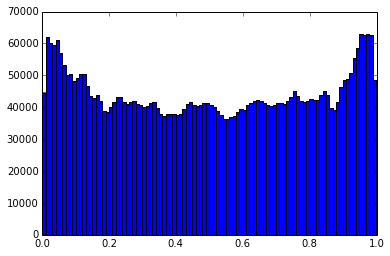

In [49]:
plt.hist(y_hat_raw.ravel(), bins=100);